# 分类非平衡问题

In [175]:
from sklearn.datasets import make_classification
from Chemometrics.utils import plot_PCA, plot_cm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold,cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'

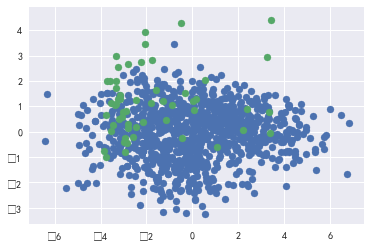

In [137]:
seed = 1
np.random.seed(seed)
X, y = make_classification(n_samples=1000, weights=[.95])
pca = plot_PCA(X, y)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
lr = LogisticRegression(class_weight='balanced')

In [209]:
cv = StratifiedKFold(n_splits=5)
# 交叉验证方式的选择， todo
params = {'C': np.power(2., range(-10, 5)), 'class_weight': [None, 'balanced']}
lr_grid = GridSearchCV(lr, param_grid=params, cv=cv, scoring='f1')
lr_grid = lr_grid.fit(X_train, y_train)

In [200]:
cv_.loc[:, 'param_class_weight'] = cv_.param_class_weight.map(lambda x: 'None' if x is None else x)

In [206]:
grp = cv_.groupby('param_class_weight')
grp.get_group('None').loc[:, ['mean_test_score', 'std_test_score']]

,mean_test_score,std_test_score
0,0.448898,0.076868
2,0.463921,0.090117
4,0.461458,0.117665
6,0.410857,0.154238
8,0.369472,0.168349
10,0.336139,0.215189
12,0.328469,0.207196
14,0.328469,0.207196
16,0.278480,0.160192
18,0.283303,0.170792


In [207]:
grp.get_group('balanced').loc[:, ['mean_test_score', 'std_test_score']]

,mean_test_score,std_test_score
1,0.302648,0.044610
3,0.291813,0.052844
5,0.305777,0.047246
7,0.309322,0.037284
9,0.314482,0.033124
11,0.301482,0.024815
13,0.311213,0.024665
15,0.310153,0.033241
17,0.313466,0.030158
19,0.313290,0.030527


## 从交叉验证的结果可以看出：
1. class weight为balanced的时候mean_test_score比'None'小
2. 但是std_test_score也比较小  
bias variance trade off

在这里倾向于选择std较小的balanced参数，f1没有考虑std  
todo sklearn.metric

# 使用交叉验证选择优化预测概率的阈值

最优的cutoff为0.3


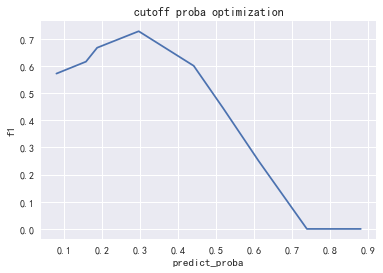

In [140]:
def get_cutoff(prob, y_true, metric=f1_score):
    """
    根据预测概率对样本进行划分，类似于决策树的分支
    """
    _py = sorted(zip(prob, y_true), key=lambda x:x[0])
    _prob, _y = zip(*_py)
    unique_p = np.unique(_prob)
    f1 = []
    for _p in unique_p:
        y_pred = _prob >= _p
        f1.append(f1_score(_y, y_pred))
    cutoff = unique_p[np.argmax(f1)]
    return cutoff, f1, unique_p
np.random.seed(5)
y_true = np.random.choice(2, 10)
prob = np.random.uniform(0, 1, 10)
cutoff, a, b= get_cutoff(prob, y_true)
plt.plot(b, a)
plt.xlabel('predict_proba')
plt.ylabel('f1')
plt.title('cutoff proba optimization')
print(f'最优的cutoff为{np.round(cutoff, 2)}')

# test set performance

0.35714285714285715

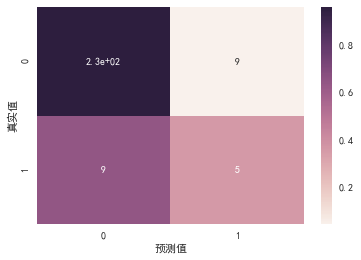

In [167]:
y_pred = lr_grid.predict(X_test)
plot_cm(y_test, y_pred)
f1_score(y_test, y_pred)

## !不要用测试集来调参数
用cross-validation

解决不平衡分类：
- 使用f1，recall，auc等作为评价指标
- 改变样本的权重class_weight
- cutoff的优化
- 重采样imbanlanced-learn (todo)